In [1]:
# This is a sample script to analyze the results of measuring talker_listener.
# Please build the trace_analysis package before using it.
# The source code used for the measurement can be found here:
# https://github.com/hsgwa/trace_samples

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
from pathlib import Path

sys.path.append(os.path.join(os.path.dirname(Path().resolve()), '..'))

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [5]:
# build and source trace_analysis package
from trace_analysis import Architecture, Application, Lttng

Failed to find record_cpp_impl. the Python version will be used.


In [6]:
trace_dir_path = './end_to_end_sample/'
lttng = Lttng(trace_dir_path, force_conversion=True)

found converted file but will re-create it: ./end_to_end_sample/converted
converting trace directory: ./end_to_end_sample
converted 8459 events in 416 ms
output written to: ./end_to_end_sample/converted
 [99%] [Ros2Handler]


In [7]:
arch = Architecture()
architecture_path = './end_to_end_sample/architecture_modified.yaml'
arch.import_file(file_path = architecture_path, file_type='yaml', latency_composer=lttng)

In [8]:
app = Application(arch)

In [9]:
node = app.nodes[0]
print('node_name: ' + node.node_name)

callback = node.callbacks[0]
print('callback_type: ' + callback.TYPE_NAME)
print('subscription topic name :' + callback.topic_name)
print('callback_name: ' + callback.callback_name)
print('callback symbol: ' + callback.symbol)
print('callback unique name: ' + callback.unique_name)

node_name: /actuator_dummy_node
callback_type: subscription_callback
subscription topic name :/topic4
callback_name: subscription_callback_0
callback symbol: ActuatorDummy::ActuatorDummy(std::__cxx11::basic_string<char,std::char_traits<char>,std::allocator<char>>,std::__cxx11::basic_string<char,std::char_traits<char>,std::allocator<char>>)::{lambda(std::unique_ptr<sensor_msgs::msg::Image>)#1}
callback unique name: /actuator_dummy_node/subscription_callback_0


node_name:  /message_driven_node
callbacks:
/message_driven_node/subscription_callback_0
/message_driven_node/subscription_callback_1


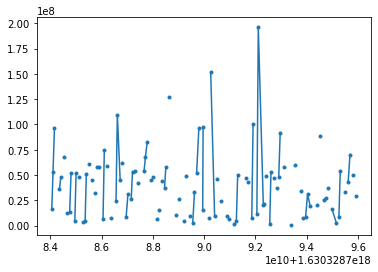

In [10]:
node = app.nodes[2]
print('node_name: ', node.node_name)

node_path = node.paths[0]
print('callbacks:')
print(node_path)
t, latency = node_path.to_timeseries()
plt.plot(t, latency, marker='.')

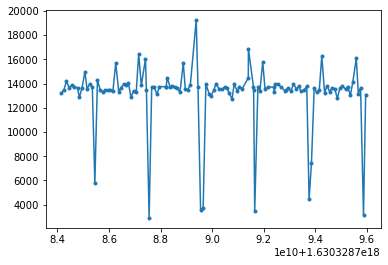

In [11]:
callback = app.callbacks[0]
t, latency = callback.to_timeseries(remove_dropped=True)
plt.plot(t, latency, marker='.')

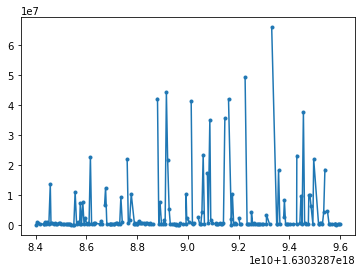

In [12]:
comm = app.communications[0]
pub_sub = comm.to_pubsub_latency()
t,latency =pub_sub.to_timeseries()
plt.plot(t, latency, marker='.')

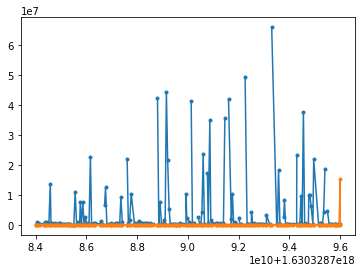

In [13]:
pubsub = comm.to_pubsub_latency()
t,latency =pubsub.to_timeseries()
plt.plot(t, latency, marker='.')

dds = comm.to_dds_latency()
t,latency =dds.to_timeseries()
plt.plot(t, latency, marker='.')

In [14]:
start_callback_unique_name = app.callbacks[6].unique_name
end_callback_unique_name = app.callbacks[0].unique_name
print('path search')
print('start_callback: ' + start_callback_unique_name)
print('end_callback: ' + end_callback_unique_name)

path search
start_callback: /sensor_dummy_node/timer_callback_0
end_callback: /actuator_dummy_node/subscription_callback_0


In [15]:
app.nodes[2].callbacks

In [16]:
paths = app.search_paths(start_callback_unique_name, end_callback_unique_name)
path = paths[0]

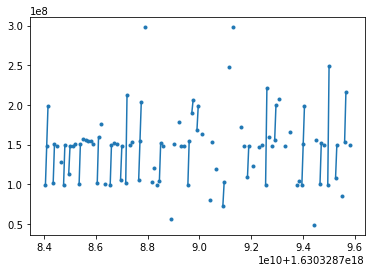

In [17]:
t, latency = path.to_timeseries()
plt.plot(t, latency, marker='.')

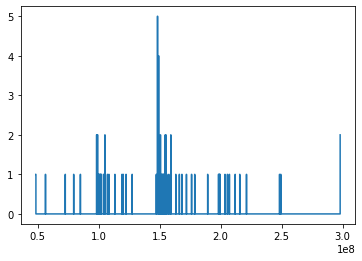

In [18]:
histogram, bins = path.to_histogram(binsize_ns=100000)
plt.step(bins[:-1], histogram, where='post')

In [19]:
df = path.to_dataframe()

In [20]:
import itertools
show_column_names_part = ['callback_start', 'callback_end']
show_column_names = []
for column_name, part in  itertools.product(df.columns, show_column_names_part):
    if part in column_name:
        show_column_names.append(column_name)

([<matplotlib.axis.YTick at 0x7f7df70f05b0>,
 <a list of 14 Text yticklabel objects>)

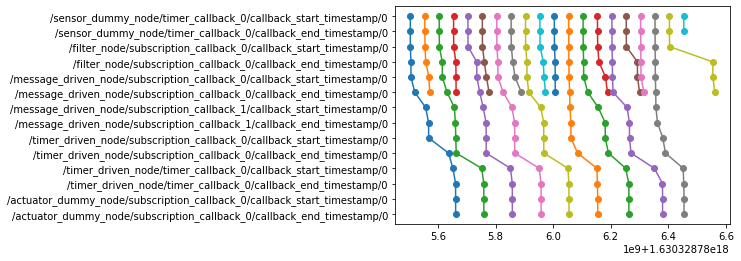

In [21]:
df_filtered = df[show_column_names]
for i, row in list(df_filtered.iterrows())[30:50]:
    x = row.values
    y = np.array(range(len(x))) * -1
    plt.plot(x, y, marker='o')

plt.yticks(y, df_filtered.columns)